In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import freeze_support

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

from timeit import default_timer as timer

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
print()

CUDA is not available.  Training on CPU ...



In [3]:
## First we load and normalize CIFAR10 using torch vision:

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# development set - includes training and validation sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0) 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Trying to show some of the training images to test it out
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
## Define the Convolutional Neural Network architecture
class Net(nn.Module):
   

    def __init__(self):
        
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


net = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [6]:
## Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
## Train the network    
train_losses = [] # track losses for plotting
train_accuracies = []
correct_train = 0
total_train = 0
test_losses = []
test_accuracies = []
correct_test = 0
total_test = 0

print('\nStart Training\n')

# time the model over epochs
start_time = timer()
num_epochs = 30

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print(f'[Epoch: {epoch + 1}]')
    
    net.train()
    running_loss = 0.0
    # calculate training losses
    for i, data in enumerate(trainloader, 0): # note trainloader has 12500 batches
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print loss statistics
        running_loss += loss.item()
    print(f'Training loss: {running_loss / len(trainloader):.3f}')
    train_losses.append(running_loss / len(trainloader)) # check            
            
    net.eval()
    with torch.no_grad():
        # calculate training accuracies
        correct_train = 0
        total_train = 0
        i = 0
        for data in trainloader: # note trainloader has 12500 batches
            inputs, labels = data
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            i += 1
        train_accuracy = 100 * correct_train / total_train
        print(f'Train accuracy: {train_accuracy}') # check
        train_accuracies.append(train_accuracy)
        print(f'----------')
        
        # calculate test losses and accuracies
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        for data in testloader:
            inputs, labels = data

            # forward pass
            # calculate outputs by running images through the network
            outputs = net(inputs)

            # calculate test losses
            loss = criterion(outputs, labels)
            running_loss += loss.item()        

            # calculate test accuaracies
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
        print(f'Test loss: {running_loss / len(testloader):.3f}') # check
        test_losses.append(running_loss / len(testloader)) # store losses to plot later
        
        test_accuracy = 100 * correct_test / total_test
        print(f'Test accuracy: {test_accuracy}') # check
        test_accuracies.append(test_accuracy)
                  
        print(f'----------\n')
        
        
print('Finished Training\n')

end_time = timer()
total_time = end_time - start_time
print(f'Training time: {total_time} seconds')

# save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


Start Training

[Epoch: 1]
Training loss: 1.461
Train accuracy: 60.532
----------
Test loss: 1.148
Test accuracy: 59.68
----------

[Epoch: 2]
Training loss: 0.893
Train accuracy: 75.218
----------
Test loss: 0.764
Test accuracy: 73.61
----------

[Epoch: 3]
Training loss: 0.690
Train accuracy: 80.542
----------
Test loss: 0.667
Test accuracy: 76.53
----------

[Epoch: 4]
Training loss: 0.560
Train accuracy: 85.576
----------
Test loss: 0.577
Test accuracy: 80.07
----------

[Epoch: 5]
Training loss: 0.470
Train accuracy: 86.09
----------
Test loss: 0.599
Test accuracy: 79.34
----------

[Epoch: 6]
Training loss: 0.392
Train accuracy: 91.166
----------
Test loss: 0.523
Test accuracy: 82.21
----------

[Epoch: 7]
Training loss: 0.321
Train accuracy: 92.472
----------
Test loss: 0.523
Test accuracy: 82.43
----------

[Epoch: 8]
Training loss: 0.264
Train accuracy: 94.576
----------
Test loss: 0.531
Test accuracy: 83.13
----------

[Epoch: 9]
Training loss: 0.212
Train accuracy: 96.364
-

In [8]:
## Now we will observe how the network performs on the whole dataset
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %\n')

Training time: 15934.6599641 seconds

Accuracy of the network on the 10000 test images: 84 %



In [9]:
## Observe how individual classes performed

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
print(f'\nAccuracy for each class:\n')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{classname:5s}: {accuracy:.1f} %')


Accuracy for each class:

plane: 90.3 %
car  : 92.6 %
bird : 79.8 %
cat  : 69.7 %
deer : 77.5 %
dog  : 76.6 %
frog : 90.1 %
horse: 92.6 %
ship : 89.5 %
truck: 91.2 %


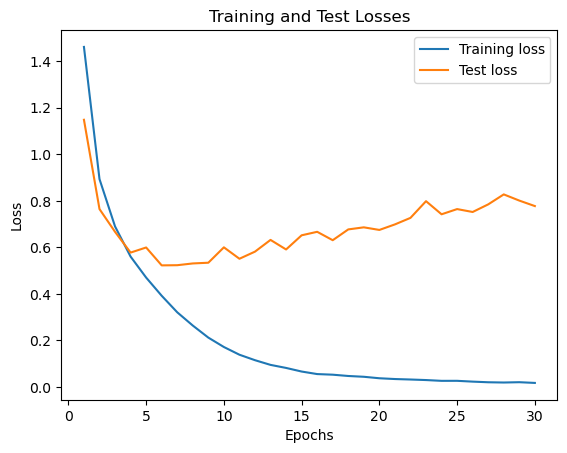

In [10]:
## Plot training and test losses over epochs 
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, test_losses, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

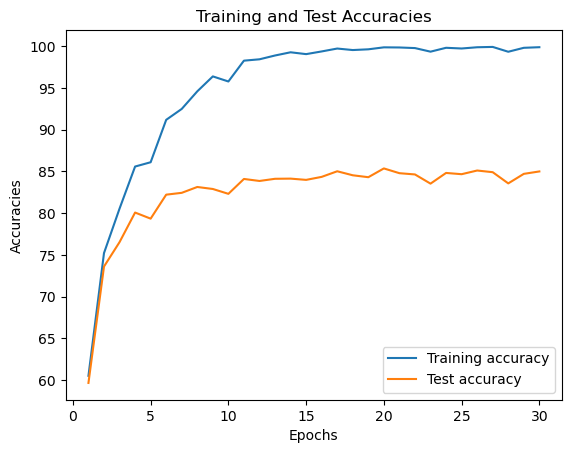

In [11]:
## Plot training and test accuracies over epochs 
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training accuracy')
plt.plot(epochs, test_accuracies, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Training and Test Accuracies')
plt.legend()
plt.show()